In [1]:
print (True)

True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=False, num_workers=12)

In [3]:
client.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41805,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38050,Total threads: 1
Dashboard: http://127.0.0.1:39575/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:41981,


In [4]:
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/projects3/ivoa_demo/gaia/catalog", 
                        columns=['ra', 'dec', 'bp_rp', 
                                'parallax', 'parallax_over_error', 
                                'phot_g_mean_mag', 
                                'pmra', 'pmdec', 
                                'classprob_dsc_combmod_star', 
                                'logg_gspphot',
                                'teff_gspphot'])

ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14", 
                       columns=['ra', 'dec', 'ps1_objid', 
                               'nobs_g', 'nobs_r', 'nobs_i', 
                               'Npix'])

#sources load takes a minute, since it creates a healpix alignment on load
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source",
                        columns=['index', 'ps1_objid',
                                       'ra', 'dec', 
                                       'catflags', 
                                       'fieldID', 
                                       'mjd', 'band', 'mag', 'magerr', 'Npix'])

In [5]:
# crossmatch ZTF + Gaia
_all_sky = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5").compute()


2023-12-10 13:32:30,147 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2023-12-10 13:33:16,412 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2023-12-10 13:33:40,154 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-12-10 13:34:09,922 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2023-12-10 13:34:14,732 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2023-12-10 13:34:23,665 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-12-10 13:34:35,409 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2023-12-10 13:34:56,283 - distributed.utils_perf - WARNING - full garbage collections took

Text(0, 0.5, 'dec [deg]')

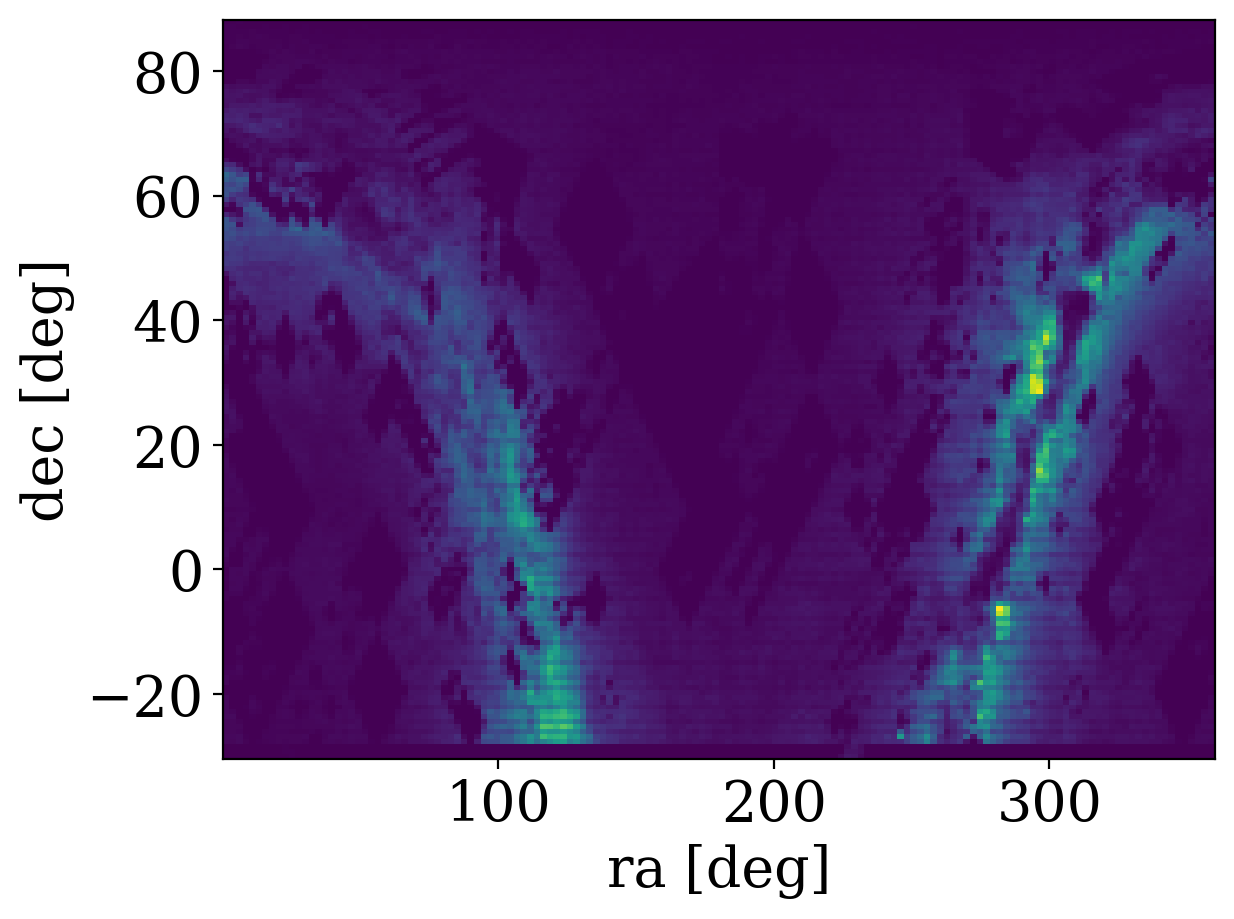

In [6]:
_ = plt.hist2d(_all_sky['ra_gaia'], _all_sky['dec_gaia'], bins=(150, 150))
plt.xlabel("ra [deg]")
plt.ylabel('dec [deg]')

In [7]:
# catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1e10
)

# don't compute table...
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
)

In [8]:
print (f"Number of unique sources: {len(_all_sky.index.unique())}")

Number of unique sources: 4833834


In [20]:
# select only good catalog detections
good_detections_table = ss.query("catflags==0 and band!='i'")

In [21]:
good_detections_table

,ra_gaia,dec_gaia,bp_rp_gaia,parallax_gaia,parallax_over_error_gaia,phot_g_mean_mag_gaia,pmra_gaia,pmdec_gaia,classprob_dsc_combmod_star_gaia,logg_gspphot_gaia,teff_gspphot_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,Npix_ztf_dr14,_DIST,index,ps1_objid,ra,dec,catflags,fieldID,mjd,band,mag,magerr,Npix
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,int32,int32,int32,float64,int64,int64,float64,float64,int16,int16,float64,string,float32,float32,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## TAPE

In [22]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [23]:
# Initialize an Ensemble
ens = Ensemble(client=client.client)
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41805,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 35 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38050,Total threads: 1
Dashboard: http://127.0.0.1:39575/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:41981,


In [24]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# We can read from parquet
ens.from_dask_dataframe(
    source_frame=good_detections_table._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

## Save pq file for source detections

In [25]:
#import pyarrow as pa

# Get a sample of the data to infer the schema
#sample_data = good_detections_table._ddf.head()

#infered_schema = pa.Schema.from_pandas(sample_data, preserve_index=False)

#good_detections_table._ddf.to_parquet(
#    f"{pth}/all_sky_fg_good_detections_table.parquet",
#    schema=infered_schema)

In [26]:
import astropy.stats as astro_stats

def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def frac_above_dev(dev):
    """Calculate the fraction of detections above 2 sigma from the deviation"""
    M = np.median(dev)
    # fraction above 2-sigma from the M
    two_sig = M + 2*np.std(dev)
    
    if len(dev)>0:
        return len(dev[dev>two_sig])/len(dev)
    else:
        return 0


def assymetry_yso_M(mag):
    """Calculate the magnitude assymetry score defined by Hillenbrand et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8/pdf).

    Described in the paper: 
    Objects that have M values <0 are predominately brightening,
    objects with M values >0 are predominantly dimming, and
    objects with M values near 0 have symmetric light curves.

    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    
    Returns:
    --------
    assymetry (float): Assymetry score.
    """
    
    if len(mag)>0:
        mag_decile = np.percentile(mag, 10)

        return (mag_decile - np.nanmedian(mag))/np.nanstd(mag)
    else:
        return 0

In [27]:
# output columns
output_cols = ["median", "frac_dev", "M_stat"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

def calc_biweight_lc(time, mag, mag_err, flag, band):
    """custom function"""
    rmv = (band=='r')
    
    time, mag, mag_err, flag, band = time[rmv], mag[rmv], mag_err[rmv], flag[rmv], band[rmv]
    
    # sort times
    xs = np.argsort(time)
    
    time, mag, mag_err, flag = time[xs], mag[xs], mag_err[xs], flag[xs]
    
    # compute features
    _f = frac_above_dev(deviation(mag, mag_err))
    _M = assymetry_yso_M(mag)
    
    return pd.Series([np.median(mag), _f, _M],
                     index=output_cols)

In [28]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    calc_biweight_lc,
    'mjd', 'mag', 'magerr', 'catflags','band',
    meta=my_meta,
    use_map=True, 
    compute=False)

CPU times: user 224 ms, sys: 23.6 ms, total: 247 ms
Wall time: 242 ms


In [29]:
demo = calc_.head(10_000, npartitions=1_000)

In [30]:
len(demo)

10000

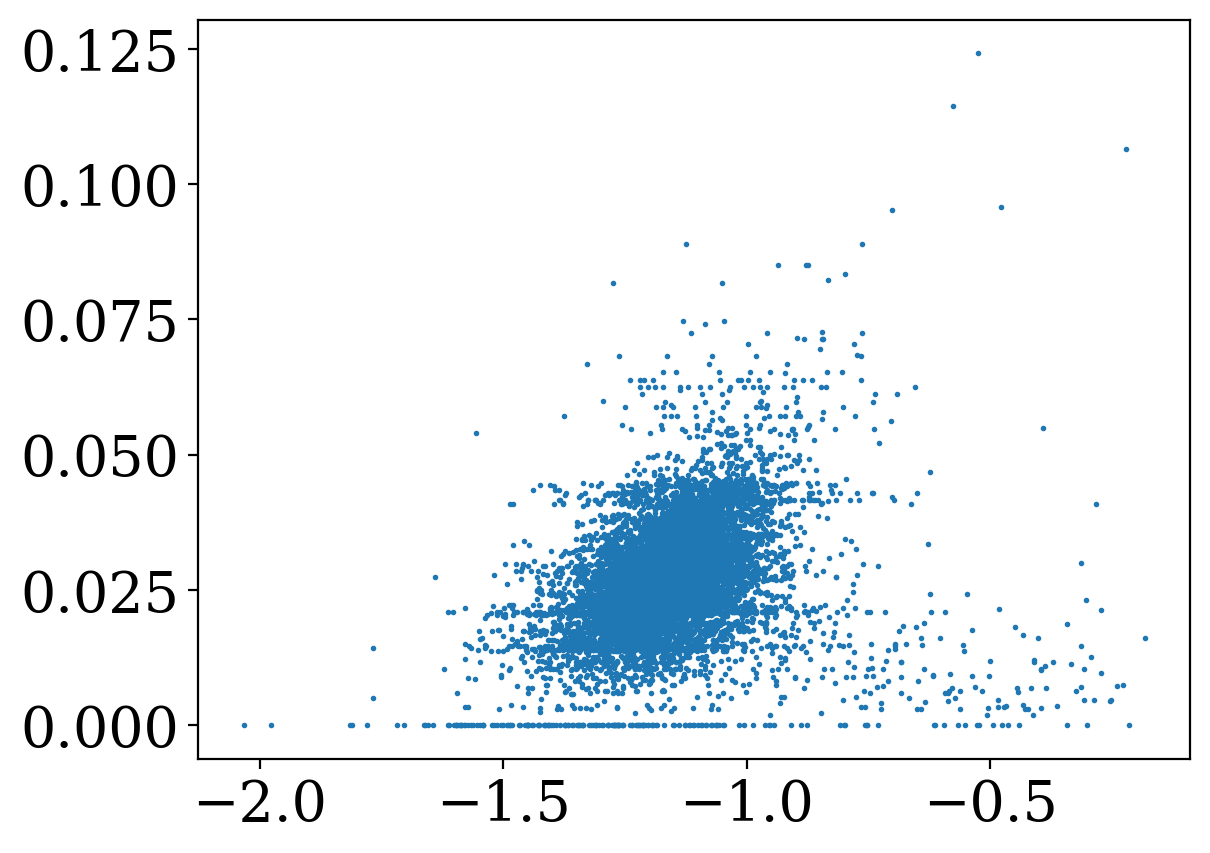

In [33]:
plt.scatter(demo['M_stat'], demo['frac_dev'], s=1)


In [ ]:
demo[(demo['M_stat']>-0.5 )& (demo['frac_dev']>0.1)]

,median,frac_dev,M_stat
_hipscat_index,,,
32032828166242304,13.624913,0.106452,-0.221983
175081026106687488,15.914543,0.135739,-0.316925
309910945860157441,16.540283,0.111111,-0.177352
350212835906682880,16.869917,0.104247,-0.222186


In [103]:
phot = ens.query('_hipscat_index==32032828166242304')